# `linselect` -- a tech sector stock analysis

Here, we demonstrate basic `linselect` calls through analyzing the daily percentage lifts of 50 tech stocks over one trading year.

Contents:
  * Load data, plot helpers, examine some stock traces
  * FwdSelect, RevSelect; supervised, single target
  * FwdSelect, RevSelect; supervised, multiple targets
  * FwdSelect, RevSelect; unsupervised (feature selection analog of PCA)
  * GenSelect

Note: plots below require `matplotlib`.

### Load prepared tech stock data set, packages


<b>Step 1:</b> Load the data and define / extract some variables:<br>
  - Data matrix, `x`
  - Array of trading dates, `dates`
  - List of stocks, `STOCK_TICKERS`

In [1]:
from linselect import FwdSelect, RevSelect, GenSelect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('stocks.csv')
print df.iloc[:3, :5]
print df.shape

         date      AAPL      ADBE       ADP      ADSK
0  2017-04-18 -0.004442 -0.001385  0.000687  0.004884
1  2017-04-19 -0.003683  0.003158  0.001374  0.017591
2  2017-04-20  0.012511  0.009215  0.009503  0.005459
(248, 51)


<b> Step 2</b>: Plot some stock traces.<br>
*Lesson*: The fluctuations of the different stocks are often highly correlated.  Below, we will be using `linselect` to find minimal subsets of the 50 stocks that we can use to develop good linear fits to one, multiple, or all of the others.

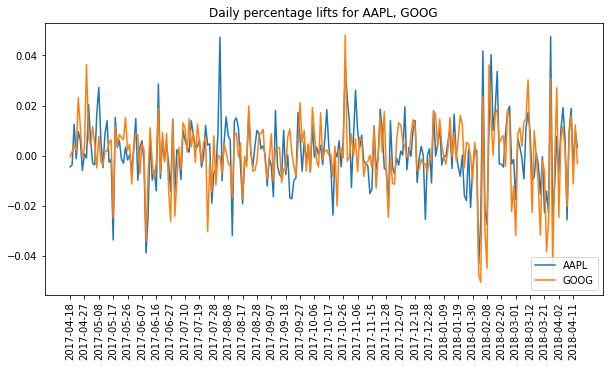

In [2]:
def stock_plot(tickers):
    """
    Plot percentage change by date for each ticker. 
    """
    fig, ax = plt.subplots(figsize=(10,5))
    for ticker in tickers:
        y = df[ticker].values
        plt.plot(y, label=ticker)
    plt.title('Daily percentage lifts for {target}'.format(
        target=', '.join(tickers)))
    plt.xticks(np.arange(df.shape[0])[::7], rotation=90)
    ax.set_xticklabels(df['date'].values[::7])
    ax.legend(loc="lower right")
    plt.show()
    
stock_plot(['AAPL', 'GOOG'])

<b> Step 3</b>: Define a plot helper we'll use repeatedly below

In [3]:
def comparison_plots(features, targets, selectors):
    """
    Examine output of one or more forward or reverse selectors.
    """
    fig, ax = plt.subplots(figsize=(10,5))
    labels = []
    for selector in selectors:
        plt.plot(selector.ordered_cods, 'o', label=str(selector.__class__)[-11:-2])
        plt.xticks(np.arange(0, len(features)), rotation=90)
        plt.title('Coefficient of Determination (COD or R^2) for {target} vs features retained'.format(
            target=', '.join(targets)))
        labels.append(
            [features[i] for i in selector.ordered_features])
            
    ax.set_xticklabels(
        [', '.join(row) for row in zip(*labels)])
    ax.legend(loc="lower right")
    plt.gca().set_ylim(bottom=0)
    plt.show()

### FwdSelect and RevSelect, single target

Goal: Identify subsets of the stocks that can be used to fit a given target stock well -- using the linear stepwise strategy.

   -  First we carry out a FwdSelect process to identify good choices.
   -  Next, we check that the COD found for a given number of features agrees with `numpy`
   -  Finally, we compare the FwdSelect and RevSelect results

<b>Step 1</b>: Use FwdSelect to seek the best stocks to fit `AAPL` performance. <br>
*Lesson*: The top 3 features provide most of the benefit here, and the others offer marginal improvements.

[25, 7, 41]
[0.43813848, 0.54534304, 0.58577418]


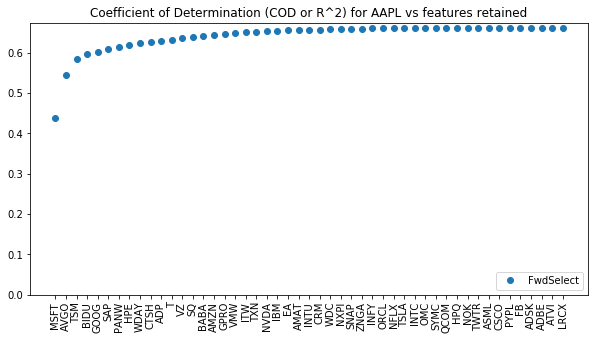

In [4]:
# Define X, y variables
def get_feature_tickers(targets):
    all_tickers = df.iloc[:, 1:].columns
    return list(c for c in all_tickers if c not in targets) 
    
TARGET_TICKERS = ['AAPL']
FEATURE_TICKERS = get_feature_tickers(TARGET_TICKERS)

X = df[FEATURE_TICKERS].values
y = df[TARGET_TICKERS].values

# Forward step-wise selection
selector = FwdSelect()
selector.fit(X, y)

# Print out main results of selection process (ordered feature indices, CODs)
print selector.ordered_features[:3]
print selector.ordered_cods[:3]

# Plot all results -- the COD vs features retained (y value is the COD that applies when using the first x features)
comparison_plots(FEATURE_TICKERS, TARGET_TICKERS, selectors=[selector])

<b>Step 2</b>: Check COD (R^2) agreement with numpy's `linalg.lstsq` <br>
*Lesson*: linselect's COD / r^2 gives results consistent with `numpy`!


In [5]:
# Choose number of features to use.
FEATURES_RETAINED = 3

# Normalize variables, carry out linear fit using numpy
# (shift-scale needed for comparison as linselect always does this)
X = df[FEATURE_TICKERS].iloc[:, selector.ordered_features[:FEATURES_RETAINED]]
X = (X - X.mean(axis=0)) / X.std(axis=0)
y_norm = (y - np.mean(y)) / np.std(y)
squared_error = np.linalg.lstsq(X, y_norm)[1]

# Check agreement
print selector.ordered_cods[FEATURES_RETAINED - 1], 1 - np.sum(squared_error) / df.shape[0]

0.585774 0.585774190658


<b>Step 3</b>:  Compare `FwdSelect` and `RevSelect` <br>
*Lesson*:  `FwdSelect` tends to outperform (underperform) `RevSelect` when few (many) features are retained.


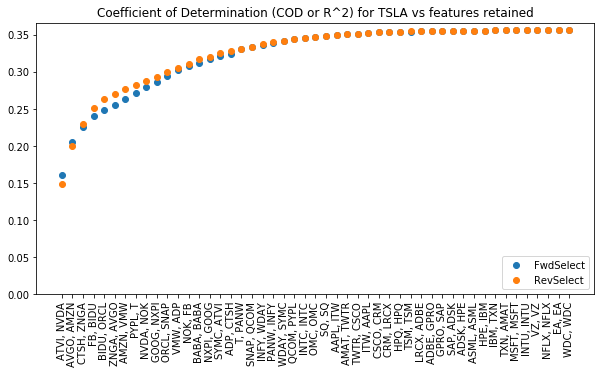

In [6]:
# Define X, y variables
TARGET_TICKERS = ['TSLA']
FEATURE_TICKERS = get_feature_tickers(TARGET_TICKERS)

X = df[FEATURE_TICKERS].values
y = df[TARGET_TICKERS].values

# Forward step-wise selection
selector = FwdSelect()
selector.fit(X, y)

# Reverse step-wise selection
selector2 = RevSelect()
selector2.fit(X, y)

# Comparison plots
comparison_plots(FEATURE_TICKERS, TARGET_TICKERS, [selector, selector2])

### FwdSelect and RevSelect, multiple targets

<b>Step 1</b>: Attempt to find feature subsets that perform well when fitting multiple targets simultaneously. <br>
*Lesson*: `linselect` can be used to find best features for a combinations of targets. The optimal, "perfect score" cod in this case is equal to number of targets.

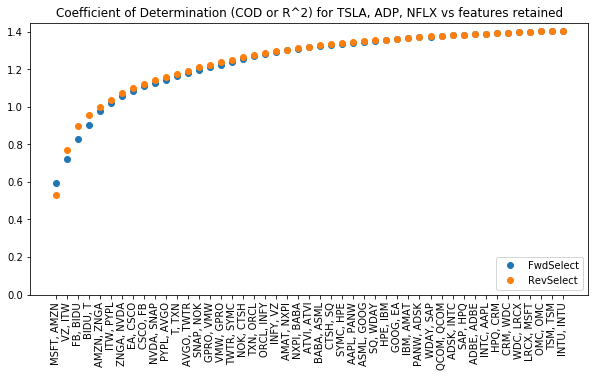

In [7]:
# Define X, y variables
TARGET_TICKERS = ['TSLA', 'ADP',  'NFLX']
FEATURE_TICKERS = get_feature_tickers(TARGET_TICKERS)

X = df[FEATURE_TICKERS].values
y = df[TARGET_TICKERS].values

# Forward step-wise selection
selector = FwdSelect()
selector.fit(X, y)

# Reverse step-wise selection
selector2 = RevSelect()
selector2.fit(X, y)

# Comparison plot
comparison_plots(FEATURE_TICKERS, TARGET_TICKERS, [selector, selector2])

### FwdSelect and RevSelect, unsupervised

Here, we find those features that give us a best fit to / linear representation of the whole set.  This goal is analogous to that addressed by PCA, but is a feature selection variant:  Whereas PCA returns a set of linear combinations of the original features, the approach here will return a subset of the original features.  This has the benefit of leaving one with a feature subset that is interpretable.

<b>Step 1</b>: Use both `FwdSelect` and `RevSelect` to find good subsets that are representative of the full set.<br>
*Lesson*: Unsupervised selection seeks to find those features that best describe the full data set -- a feature selection analog of PCA.

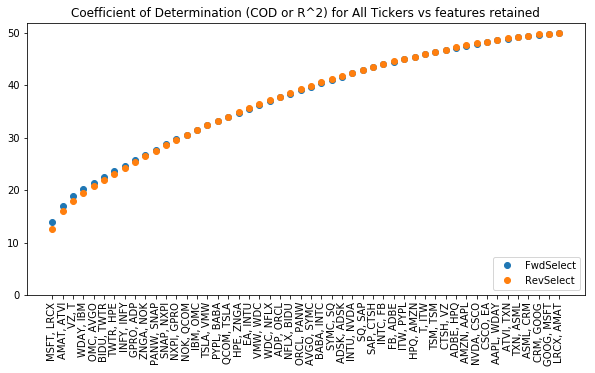

In [8]:
# Set X equal to full data set.
ALL_TICKERS = list(df.iloc[:, 1:].columns)
X = df[ALL_TICKERS].values

# Stepwise regressions
selector = FwdSelect()
selector.fit(X)

selector2 = RevSelect()
selector2.fit(X)

# Comparison plots
comparison_plots(ALL_TICKERS, ['All Tickers'], [selector, selector2])

## GenSelect

`GenSelect`'s api is designed to expose the full flexibility of the efficient linear stepwise algorithm. Because of this, it is more complex than that of `FwdSelect` and `RevSelect`.  Here, our aim is to quickly demo this api.  Essential ingredients:  (a) We pass only a single data matrix `X`, and must specify which columns are the predictors and which are targets.  (b) Because we might sweep up and down, we cannot define an `ordered_features` as in `FwdSelect` and `RevSelect` (the best subset of size three now may not contain the features in the best subset of size two).  Instead, we have a dictionary `best_results` that stores information on the best results seen so far for each possible feature count.  (c) We can move back and forth, adding features to or removing them from the feature set.  We can specify the search protocol for doing this.  (d) We can reposition our search to any feature location and continue the search from there.  (e) We can access the costs of each possible move from our current location, without stepping.

If an `m x n` data matrix `X` is passed to `GenSelect`, three Boolean arrays define the state of the search.
  - `s` -- This array specifies which of the `n` columns features are currently being used as predictors.
  - `targets` -- This specifies which of the `n` features are the target variables (analogs of `y` in `FwdSelect` and `RevSelect`).
  - `mobile` -- This specifies which of the `n` features are locked into or out of our fit -- those that are not mobile are marked `False`.  
  
Note: We usually want the targets to not be mobile -- though this is not the case in unsupervised applications.  One might sometimes also want to lock certain features into the predictor set, and `mobile` can be used to do this.

<b>Step 1</b>: Use GenSelect to carry out a forward sweep on a single target. <br>
*Lesson*: How to setup a basic `GenSelect` call.

In [9]:
# Define X
X = df[ALL_TICKERS].values

# Define targets and mobile Boolean arrays
TARGET_TICKERS = ['TSLA']
FEATURE_TICKERS = get_feature_tickers(TARGET_TICKERS)
targets = np.in1d(ALL_TICKERS, TARGET_TICKERS)
mobile = np.in1d(ALL_TICKERS, FEATURE_TICKERS)

# Set up search with an initial `position`.  Then search.
selector = GenSelect()
selector.position(X, mobile=mobile, targets=targets)
selector.search(protocol=(1, 0), steps=X.shape[1])

# Review best 3 feature set found
print np.array(ALL_TICKERS)[selector.best_results[3]['s']], selector.best_results[3]['cod']

['ATVI' 'AVGO' 'CTSH'] 0.225758


<b>Step 2</b>:  Reposition and sweep back and forth to better explore region.<br>
*Lesson*:  We can carry out general search protocols using `GenSelect` by using its `position` and `search` methods.

In [10]:
# Reposition back to the best fit of size 3 seen above.
s = selector.best_results[3]['s']
selector.position(s=s)

# Now sweep back and forth around there a few times.
STEPS = 10
SWEEPS = 3

selector.search(protocol=(0, 1), steps=STEPS)
selector.search(protocol=(2 * STEPS, 2 * STEPS), steps=SWEEPS * 4 * STEPS)

# Review best results found now with exactly N_RETAINED features (different from first pass in cell above?)
print np.array(ALL_TICKERS)[selector.best_results[3]['s']], selector.best_results[3]['cod']

['AMZN' 'NVDA' 'ZNGA'] 0.229958


<b>Step 3</b>: Compare COD values to those from `FwdSelect` and `RevSelect`<br>
*Lesson*: `GenSelect` can be used to do a more thorough search than `FwdSelect` and `RevSelect`, and so can sometimes find better feature subsets.

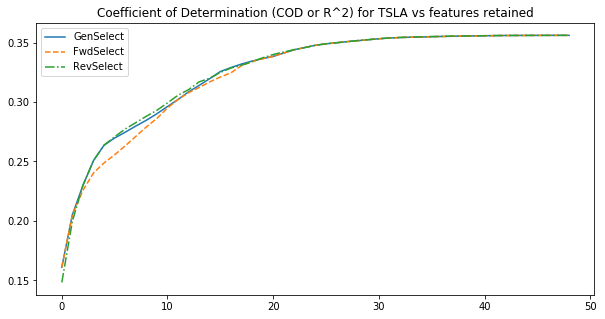

In [11]:
# Get the best COD values seen for each feature set size from GenSelect search
gen_select_cods = []
for i in range(1, X.shape[1]):
    if i not in selector.best_results:
        break
    gen_select_cods.append(selector.best_results[i]['cod'])

# Plot cod versus feature set size.
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(gen_select_cods, label='GenSelect')

# FwdSelect again to get corresponding results.
selector2 = FwdSelect()
selector2.fit(X[:, mobile], X[:, targets])
plt.plot(selector2.ordered_cods,'--', label='FwdSelect')

# RevSelect again to get corresponding results.
selector3 = RevSelect()
selector3.fit(X[:, mobile], X[:, targets])
plt.plot(selector3.ordered_cods, '-.',label='RevSelect')
plt.title('Coefficient of Determination (COD or R^2) for {target} vs features retained'.format(
        target=', '.join(TARGET_TICKERS)))
plt.legend()
plt.show()

<b>Step 4</b>:  Examine the cost of removing a feature from the predictor set.<br>
*Lesson*:  We can easily access the costs associated with movement from a location.

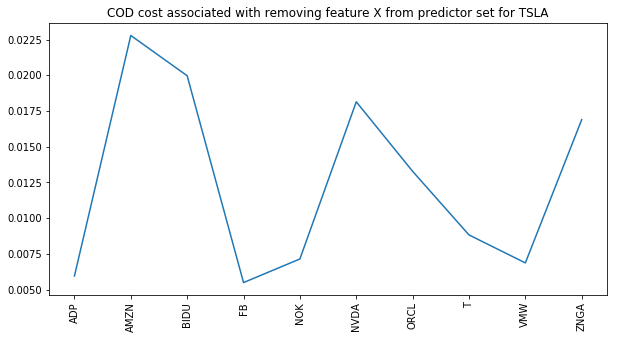

In [12]:
# Reposition
s = selector.best_results[10]['s']
selector.position(s=s)

# Get costs to remove a feature (see also `forward_cods` method)
costs = selector.reverse_cods()[s]
TICKERS = np.array(ALL_TICKERS)[selector.best_results[10]['s']]

# Plot costs to remove each feature given current position
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(costs)
plt.xticks(np.arange(0, len(TICKERS)), rotation=90)
plt.title('COD cost associated with removing feature X from predictor set for {target}'.format(
        target=', '.join(TARGET_TICKERS)))

ax.set_xticklabels(TICKERS)
plt.show()